In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

# 1.加载数据集
#数据集的格式为matlab格式，所以要用到loadmat进行加载
#数据集为5000个训练样本，每个样本为20*20像素的灰度图像。
def load_data(path):
    data = loadmat(path)
    X = data['X']
    y = data['y']
    return X,y

X,y = load_data('ex3data1.mat')
X.shape,y.shape

((5000, 400), (5000, 1))

随机打印一个训练样本


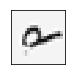

this number should be [9]


In [2]:
# 2.可视化数据
#由于是5000个训练样本，所以只将其中一个训练样本进行可视化
def plot_an_image(X):
    print('随机打印一个训练样本')
    pick_one = np.random.randint(0,5000)   #实际的取值范围是[0,4999]
    image = X[pick_one,:]   #image的维度（1,400）代表一个样本的400个灰度值
    fig,ax = plt.subplots(figsize=(1,1))
    ax.matshow(image.reshape((20,20)),cmap='gray_r')
    plt.xticks([])    #去除刻度，目的是更美观
    plt.yticks([])
    plt.show()
    print('this number should be {}'.format(y[pick_one]))
    
plot_an_image(X)

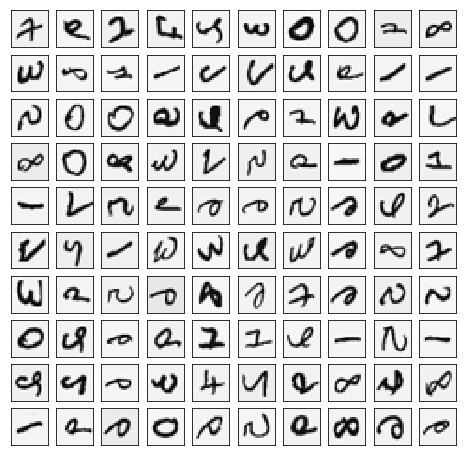

In [3]:
# 随机画100个数字
def plot_100_images(X):
    index = np.random.choice(5000,100)
    images = X[index,:]  #images:100张训练样本（随机选取），其维度是（100*400）
    fig,ax_array = plt.subplots(nrows=10,ncols=10,sharex=True,sharey=True,figsize=(8,8))
    
    #通过for循环来填充这个10*10的网格
    for row in range(10):
        for col in range(10):
            ax_array[row,col].matshow(images[10*row + col].reshape((20,20)),cmap='gray_r')
            
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_100_images(X)

In [4]:
# 3.Vectorizing Logistic Regression 向量化逻辑回归（把所有的需要使用的函数，用向量实现）
def sigmoid(z):
    return 1/(1+np.exp(-z))

def regularized_cost(theta,X,y,l):
    _theta = theta[1:]   #这个_theta是用在正则化后加的惩罚项，不惩罚theta0，即新构造的_theta不包括theta0
    reg = (l/(2*len(X)))*(_theta@_theta)    #reg即为正则化需要加的penalty
    first = (-y)*np.log(sigmoid(X@theta))
    second = (y-1)*np.log(1-sigmoid(X@theta))
    return np.mean(first+second)+reg   #cost是一个数值！第一次的时候这里出了问题！
# def regularized_cost(theta, X, y, l):
#     """
#     don't penalize theta_0
#     args:
#         X: feature matrix, (m, n+1) # 插入了x0=1
#         y: target vector, (m, )
#         l: lambda constant for regularization
#     """
#     thetaReg = theta[1:]
#     first = (-y*np.log(sigmoid(X@theta))) + (y-1)*np.log(1-sigmoid(X@theta))
#     reg = (thetaReg@thetaReg)*l / (2*len(X))
#     return np.mean(first) + reg

def regularized_gradient(theta,X,y,l):
    #注意：这个只是计算（正则化）梯度！其维度跟theta的一致(都是n+1维)：因为在使用梯度下降算法来更新theta:=theta-regularized_gradient
    #计算时候技巧：原始gradient+reg
    #原始gradient：
    gradient = (1/len(X))*(X.T@(sigmoid(X@theta)-y))
    #reg项
    reg = (l/len(X))*theta    #j:[1-n]
    reg[0] = 0
    return gradient+reg         #返回n+1维的向量   

    

In [5]:
# 4.One-vs-all Classification
# 一共有K类，则需要训练K个模型（h(x)）,每个h(x)的theta参数都是不同的
from scipy.optimize import minimize

def one_vs_all(X,y,l,K):
    
    # return :trained parameters (all_theta) 
    all_theta = np.zeros((K,X.shape[1]))    #  （10,401）
    
    for i in range(1,K+1):      # i取值为[1,2,3,...7,8,9,10] 因为y向量的元素内容就是[1~10]  为什么没有0，明明
        
        theta = np.zeros(X.shape[1])   # (401,) 初始值为0
        y_i = np.array([1 if label==i else 0 for label in y])   # y :(5000,)的向量 训练集的维度
        result = minimize(fun=regularized_cost, x0=theta, args=(X, y_i, l), method='TNC',jac=regularized_gradient)
        all_theta[i-1,:] = result.x    #all_theta[0]是第一个模型(共10个)的所有参数，维度(401,)
    return all_theta
#from scipy.optimize import minimize

#def one_vs_all(X, y, l, K):
#    """generalized logistic regression
#    args:
#        X: feature matrix, (m, n+1) # with incercept x0=1
#        y: target vector, (m, )
#        l: lambda constant for regularization
#        K: numbel of labels
#    return: trained parameters
#    """
#    all_theta = np.zeros((K, X.shape[1]))  # (10, 401)
#    
#    for i in range(1, K+1):
#        theta = np.zeros(X.shape[1])
#        y_i = np.array([1 if label == i else 0 for label in y])
    
#        ret = minimize(fun=regularized_cost, x0=theta, args=(X, y_i, 1), method='TNC',
#                        jac=regularized_gradient, options={'disp': True})
#        all_theta[i-1,:] = ret.x
#                         
#    return all_theta


In [6]:
def predict_all(X,all_theta):
    probability = sigmoid( X@all_theta.T )    # (5000,401) × (401,10) = (5000,10)
    predictions = np.argmax(probability,axis=1)
    predictions = predictions + 1
    return predictions

In [7]:
# 5.处理原始数据
# 得到合适维度的X，y
raw_X,raw_y = load_data('ex3data1.mat')
# raw_X.shape
X = np.insert(raw_X,0,1,axis=1) 
# X.shape   
#raw_y.shape  (5000, 1) 即是5000行1列，不是一维数组（numpy中向量、数组表示略有不同）
y = raw_y.flatten()  #t通过reshape调整为一维数组
all_theta = one_vs_all(X,y,1,10)
all_theta

array([[-2.38217958e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30472117e-03, -8.31094214e-10,  0.00000000e+00],
       [-3.18217346e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.45647116e-03, -5.08050431e-04,  0.00000000e+00],
       [-4.79952509e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.81942224e-05, -2.44087163e-07,  0.00000000e+00],
       ...,
       [-7.98546577e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.95027799e-05,  7.21450660e-06,  0.00000000e+00],
       [-4.57154903e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33113181e-03,  9.94087791e-05,  0.00000000e+00],
       [-5.40515390e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16651031e-04,  7.88784620e-06,  0.00000000e+00]])

In [8]:
y_predict = predict_all(X,all_theta)
accuracy = np.mean(y_predict == y)
print('accuracy = {0}%'.format(accuracy*100))

accuracy = 94.46%


In [9]:
# *************** Neural Networks************************
#     1. 神经网络可以实现非常复杂的非线性模型
#     2. 这里我们用已经训练好的权重（weights）来进行预测

def load_weights(path):
    weights = loadmat(path)
    return weights['Theta1'],weights['Theta2']
theta1,theta2 = load_weights('ex3weights.mat')
# theta1.shape,theta2.shape,type(theta1)

In [10]:
X,y = load_data('ex3data1.mat')
y = y.flatten()   #flatten()作用：将y从 `m行1列`【即m个数组，每个数组有1个元素】舒展成 （m，）【即是行向量，一维数组，共有m个元素】 
X = np.insert(X,0,1,axis=1)   #axis=1表示列插入
X.shape,y.shape

((5000, 401), (5000,))

In [11]:
a1 = X              # (5000,401)
z2 = theta1@a1.T    # (25,401)×(401,5000) = (25,5000)
a2 = sigmoid(z2)    # (25,5000)
a2 = np.insert(a2,0,1,axis=0)   # axis=0表示行，插入一行1之后 (26,5000)
z3 = theta2@a2      # (10,26)×(26,5000) = (10,5000)    此处，要将a2增加一行---bias （本来是25行，后来变成26行）  
a3 = sigmoid(z3)    # (10,5000)   每一列代表一个训练样本，每一列有10个元素[probability]

predictions = np.argmax(a3,axis=0) + 1   #为什么要+1？ 因为 row_index 是0~9 要加上1，使其成为1~10
predictions.shape

(5000,)

In [12]:
accuracy = np.mean(y == predictions)
print('accuracy = {0}%'.format(accuracy*100))

accuracy = 97.52%
